In [1]:
from __future__ import division
import numpy as np
import nussl
import matplotlib.pyplot as plt
import erb as erb

In [2]:
window_length = 1024
hop_length = 512
window_type = 'hann'
n_fft_bins = 2048

In [213]:
print(brir[:, 2, 3])

[ -0.23175418  -0.20225201  -0.79938173  -0.96477147  -1.11312975
  -1.55219063  -1.98541276  -2.05704238  -2.47541686  -3.47434336
  -4.13775227  -5.13858497  -6.46326816  -8.37911057 -10.06390914
 -11.78819568  -9.96928124 -12.16073502 -14.17002086 -15.37280631]


(20L, 3L, 5L)


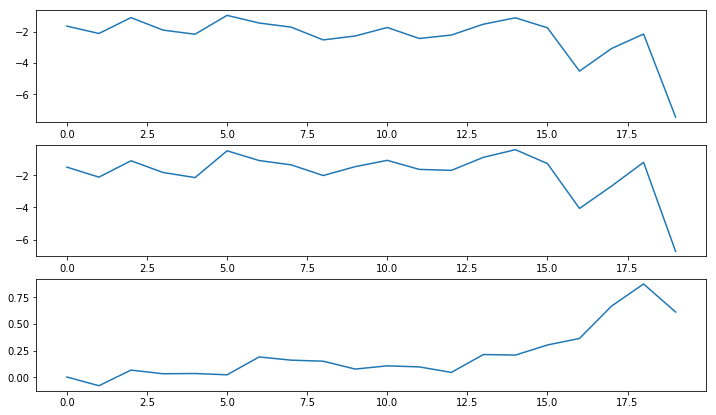

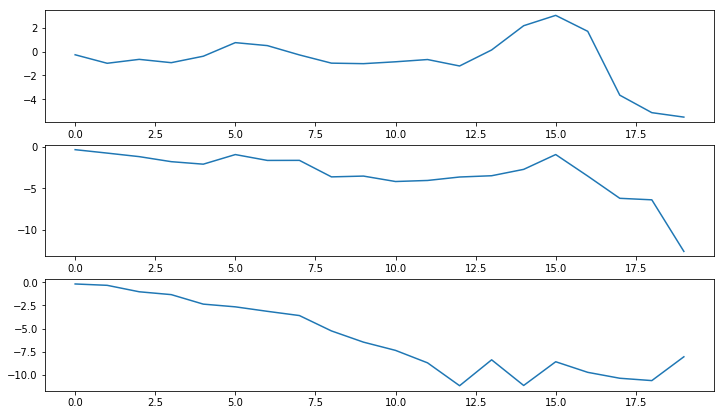

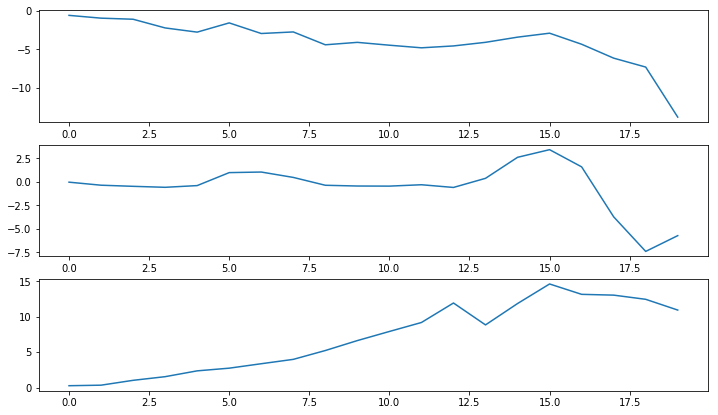

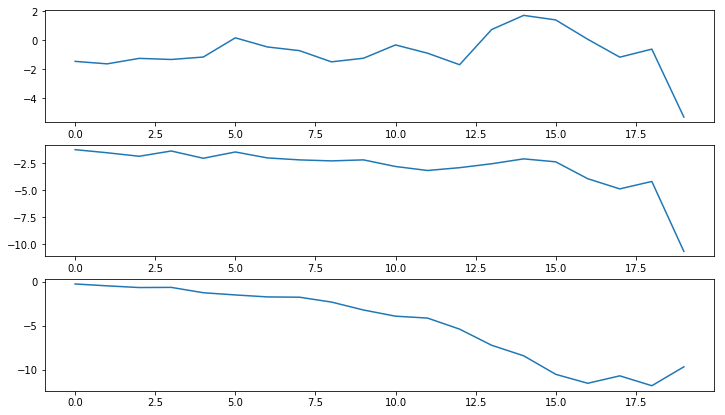

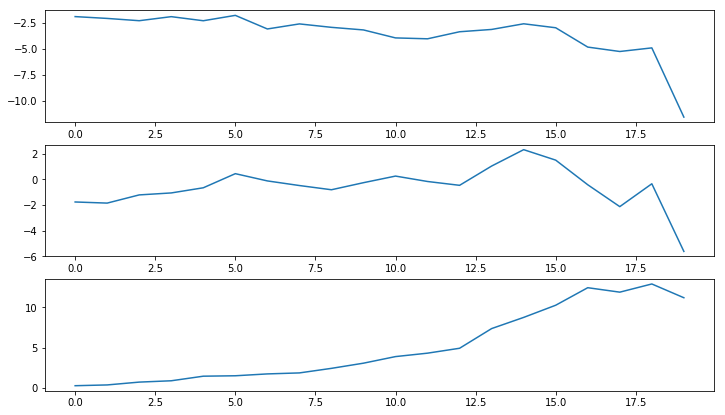

In [6]:
# preprocess BRIR 
def brir_para(brir):
    K = brir.stft_data.shape[1] // 5
    pFC = np.zeros((B, 3))
    S = brir.stft_data

    for b in range(B):
        corr = 0*1j
        for k in range(K):
            L = S[:, k, 0] * filters[:, b + 1]
            R = S[:, k, 1] * filters[:, b + 1]
            pFC[b, 0] = pFC[b, 0] + np.real(np.vdot(L, L))
            pFC[b, 1] = pFC[b, 1] + np.real(np.vdot(R, R))
            corr = corr + np.vdot(L, R)

        pFC[b, 0] = pFC[b, 0] / (K * w_filters[b+1])
        pFC[b, 1] = pFC[b, 1] / (K * w_filters[b+1])
        #pFC[b, 0] = pFC[b, 0] / K
        #pFC[b, 1] = pFC[b, 1] / K
        pFC[b, 2] = np.angle(corr)
        
    pFC[:, 0] = np.sqrt(pFC[:, 0]) * 12
    pFC[:, 1] = np.sqrt(pFC[:, 1]) * 12
    pFC[:, 2] = np.unwrap(pFC[:, 2])
    return pFC

#BRIRs = ['BRIR_FC.wav', 'BRIR_FL.wav', 'BRIR_FR.wav', 'BRIR_FLc.wav','BRIR_FRc.wav']
BRIRs = ['IIS_BRIR_A+000_E+00.wav', 'IIS_BRIR_A+060_E+00.wav', 'IIS_BRIR_A-060_E+00.wav', 'IIS_BRIR_A+030_E+00.wav', 'IIS_BRIR_A-030_E+00.wav']
brir = np.zeros((B, 3, 5))

i = 0
for brir_file in BRIRs:

    brir_sig = nussl.AudioSignal(brir_file)
    brir_sig.stft(window_length, hop_length, window_type, n_fft_bins)
    brir[:,:,i] = brir_para(brir_sig)
    i = i + 1

print(brir.shape)

if 1:
    for i in range(5):
        pFC = brir[:, :, i]
        plt.figure(figsize=(12,7))
        plt.subplot(311)
        plt.plot(10*np.log10(np.abs(pFC[:, 0])))
        plt.subplot(312)
        plt.plot(10*np.log10(np.abs(pFC[:, 1])))
        plt.subplot(313)
        plt.plot(pFC[:, 2])

48000
(1025L, 2302L, 2L)


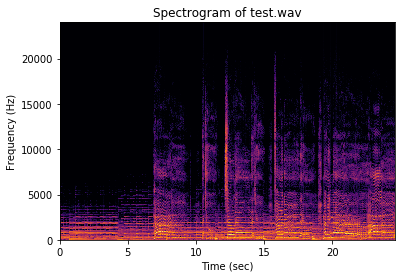

In [14]:
# Initializing from a path:
file_path = 'test.wav'
sig = nussl.AudioSignal(file_path)
sig.stft(window_length, hop_length, window_type, n_fft_bins)
sig.plot_spectrogram()
print(sig.sample_rate)
print(sig.stft_data.shape)
freqs_length = sig.stft_data.shape[0]
sample_rate = sig.sample_rate

In [273]:
print(freqs_length, sample_rate)

(1025L, 48000)


[  3.92587761   2.99082989   3.65713381   4.49408355   5.5105688
   6.75810387   8.28651306  10.15967375  12.45969372  15.28005309
  18.7376208   22.97819796  28.17852868  34.55572761  42.37618072
  51.9664569   63.72711276  78.14936087  95.83558012 117.52438862
 144.12166439 253.3266494 ]


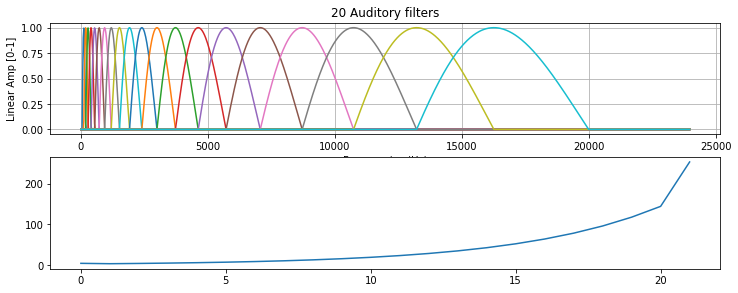

In [15]:
B = 20
# Equivalent Rectangular Bandwidth
# Create an instance of the ERB filter bank class
erb_bank = erb.EquivalentRectangularBandwidth(freqs_length, sample_rate, B, 50, 20000)
freqs = erb_bank.freqs.tolist()
filters = erb_bank.filters
#filters = np.power(filters, 2) # sin^2 

w_filters = np.sum(np.power(filters, 2), axis=0)
print(w_filters)

## Plot
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.grid(True)
plt.plot(freqs,filters[:, 1:-1])
plt.title("%s Auditory filters"%B)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Linear Amp [0-1]')
plt.subplot(312)
plt.plot(w_filters)

In [16]:
# get subband analysis of source
S = sig.stft_data
M = sig.stft_data.shape[1]
BS = np.zeros((S.shape[0], B, S.shape[1], S.shape[2]), dtype=np.complex_)
for m in range(M):
    for b in range(B):
        BS[:, b, m, 0] = S[:, m, 0] * filters[:, b + 1]
        BS[:, b, m, 1] = S[:, m, 1] * filters[:, b + 1]
        

In [17]:
# compute BS, X, Y, T 
M = sig.stft_data.shape[1]
X = np.zeros((M, B)) # real part of cross-correlation
Y = np.zeros((M, B)) # difference of powers
T = np.zeros((M, B)) # sum of powers
a = np.array([0.01, 0.01, 0.02, 0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.3, \
              0.3,  0.3,  0.3,  0.3,  0.3,  0.3, 0.3, 0.3, 0.3, 0.3])#np.ones(B) * 0.1 # smoothing coefficient 

for b in range(B):
    L = BS[:, b, 0, 0]
    R = BS[:, b, 0, 1]
    X[0, b] = 2 * np.real(np.vdot(L, R))
    Y[0, b] = np.real(np.vdot(L, L) - np.vdot(R, R))
    T[0, b] = np.real(np.vdot(L, L) + np.vdot(R, R))
    
for m in range(1, M):
    for b in range(B):
        L = BS[:, b, m, 0]
        R = BS[:, b, m, 1]
        X[m, b] = (1-a[b]) * X[m-1, b] + a[b] * 2 * np.real(np.vdot(L, R))
        Y[m, b] = (1-a[b]) * Y[m-1, b] + a[b] * np.real(np.vdot(L, L) - np.vdot(R, R))
        T[m, b] = (1-a[b]) * T[m-1, b] + a[b] * np.real(np.vdot(L, L) + np.vdot(R, R))       

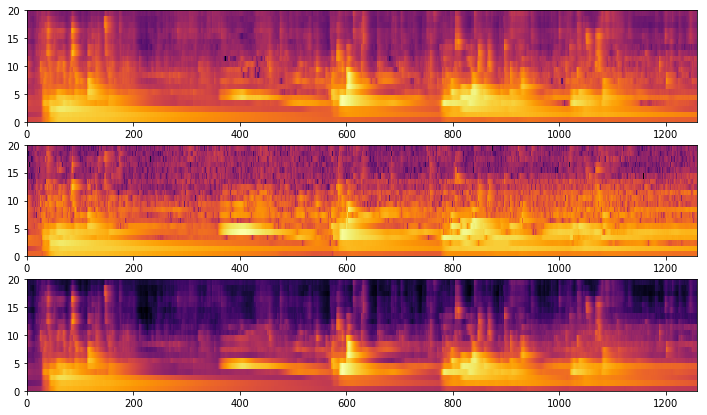

In [11]:
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.pcolormesh(10*np.log10(np.abs(np.transpose(X))), cmap="inferno")
plt.subplot(312)
plt.pcolormesh(10*np.log10(np.abs(np.transpose(Y))), cmap="inferno")
plt.subplot(313)
plt.pcolormesh(10*np.log10(np.transpose(T)), cmap="inferno")

In [18]:
# signal dependent separation matrix W
W = np.zeros((2, 2, M, B))
for m in range(M):
    for b in range(B):
        W[0, 0, m, b] = (np.sqrt(X[m,b]*X[m,b]+Y[m,b]*Y[m,b]) + Y[m,b])/(2*T[m,b])
        W[0, 1, m, b] = X[m,b]/(2*T[m,b])
        W[1, 0, m, b] = X[m,b]/(2*T[m,b])
        W[1, 1, m, b] = (np.sqrt(X[m,b]*X[m,b]+Y[m,b]*Y[m,b]) - Y[m,b])/(2*T[m,b])       

# extract direct signal
BD = np.zeros(BS.shape, dtype=np.complex_) 
for m in range(M):
    for b in range(B):
        L = BS[:, b, m, 0]
        R = BS[:, b, m, 1]
        BD[:, b, m, 0] = W[0,0,m,b]*L + W[0,1,m,b]*R
        BD[:, b, m, 1] = W[1,0,m,b]*L + W[1,1,m,b]*R
        
# extract diffuse signal        
BN = BS - BD

# synthesis direct and diffuse signal
SD = np.zeros(BS.shape, dtype=np.complex_)
SN = np.zeros(BS.shape, dtype=np.complex_)
for m in range(M):
    for b in range(B):
        SD[:, b, m, 0] = BD[:, b, m, 0] * filters[:, b + 1]
        SD[:, b, m, 1] = BD[:, b, m, 1] * filters[:, b + 1]
        SN[:, b, m, 0] = BN[:, b, m, 0] * filters[:, b + 1]
        SN[:, b, m, 1] = BN[:, b, m, 1] * filters[:, b + 1]        
    
D = np.sum(SD, axis=1)
N = np.sum(SN, axis=1)

In [19]:
# output direct and diffuse signal
sig_direct = nussl.AudioSignal(stft=D, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('direct.wav')

sig_direct = nussl.AudioSignal(stft=N, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('diffuse.wav')


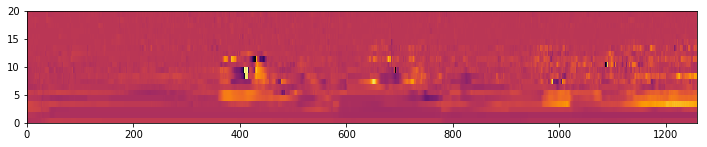

In [183]:
# panning the direct signal
Da = np.zeros(X.shape)
for m in range(M):
    for b in range(B):
        Da[m, b] = np.rad2deg(np.arctan2(Y[m, b], X[m, b]))
        
plt.figure(figsize=(12,7))
plt.subplot(311)
plt.pcolormesh(np.transpose(Da), cmap="inferno")

In [202]:
# direct process with hrtf
(FC, FL, FR, FLc, FRc) = [0, 1, 2, 3, 4]
PN = np.zeros(N.shape, dtype=np.complex_ )
# process Ambience 
for m in range(M):
    for b in range(B):
        NL = BN[:, b, m, 0] * filters[:, b + 1]        
        brirL = brir[b, 0, FL] * np.exp(-1j * brir[b, 2, FL] * 0.5)
        brirR = brir[b, 1, FL] * np.exp(1j * brir[b, 2, FL] * 0.5)
        PN[:, m, 0] = PN[:, m, 0] + NL * brirL
        PN[:, m, 1] = PN[:, m, 1] + NL * brirR
        
        NR = BN[:, b, m, 1] * filters[:, b + 1]        
        brirL = brir[b, 0, FR] * np.exp(-1j * brir[b, 2, FR] * 0.5)
        brirR = brir[b, 1, FR] * np.exp(1j * brir[b, 2, FR] * 0.5)
        PN[:, m, 0] = PN[:, m, 0] + NR * brirL
        PN[:, m, 1] = PN[:, m, 1] + NR * brirR
   
PN = PN / 6.0

sig_direct = nussl.AudioSignal(stft=PN, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('diffuse_hrtf.wav')      

In [205]:
# ambience process with hrtf
PD = np.zeros(N.shape, dtype=np.complex_ )
for m in range(M):
    for b in range(B):
        ang = Da[m, b] + 180
        if ang > 170 and ang <= 190:
            DL = (BD[:, b, m, 0] + BD[:, b, m, 1]) * 0.5 * filters[:, b + 1]        
            brirL = brir[b, 0, FC] * np.exp(-1j * brir[b, 2, FC] * 0.5)
            brirR = brir[b, 1, FC] * np.exp(1j * brir[b, 2, FC] * 0.5)
            PD[:, m, 0] = PD[:, m, 0] + DL * brirL
            PD[:, m, 1] = PD[:, m, 1] + DL * brirR            
        else:
            if ang > 0 and ang <= 120:
                bL = FL
                bR = FLc
            elif ang > 120 and ang <= 170:
                bL = FLc
                bR = FC
            elif ang > 190 and ang <=240:
                bL = FC
                bR = FRc
            else:
                bL = FRc
                bR = FR

            DL = BD[:, b, m, 0] * filters[:, b + 1]        
            brirL = brir[b, 0, bL] * np.exp(-1j * brir[b, 2, bL] * 0.5)
            brirR = brir[b, 1, bL] * np.exp(1j * brir[b, 2, bL] * 0.5)
            PD[:, m, 0] = PD[:, m, 0] + DL * brirL
            PD[:, m, 1] = PD[:, m, 1] + DL * brirR
            
            DR = BD[:, b, m, 1] * filters[:, b + 1]        
            brirL = brir[b, 0, bR] * np.exp(-1j * brir[b, 2, bR] * 0.5)
            brirR = brir[b, 1, bR] * np.exp(1j * brir[b, 2, bR] * 0.5)
            PD[:, m, 0] = PD[:, m, 0] + DR * brirL
            PD[:, m, 1] = PD[:, m, 1] + DR * brirR

sig_direct = nussl.AudioSignal(stft=PD, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('direct_hrtf.wav')        
        
# combine direct and ambience    
TT = (PN +PD * 0.5)

sig_direct = nussl.AudioSignal(stft=TT, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('total_hrtf.wav')

In [ ]:
# set parameters
window_length = 1024
hop_length = 512
window_type = 'hann'
n_fft_bins = 2048



In [ ]:

# load test file


In [240]:
# Binaural rendering by J. Breebaart
a_BS = np.zeros((B, M, 2))
v_BS = np.zeros((B, M))
b_BS = np.zeros((B, M))
g_BS = np.zeros((B, M))
SD_BS = np.zeros(BS.shape, dtype=np.complex_)

# spatial analysis
for m in range(M):
    for b in range(B):
        L = BS[:, b, m, 0]
        R = BS[:, b, m, 1]
        a_BS[b, m, 0] = np.sqrt(np.real(np.vdot(L, L)))
        a_BS[b, m, 1] = np.sqrt(np.real(np.vdot(R, R)))
        v_BS[b, m] = 0.5 * np.arccos(np.real(np.real(np.vdot(L, R)) / (a_BS[b, m, 0] * a_BS[b, m, 1])))
        b_BS[b, m] = np.tan(((a_BS[b, m, 1] - a_BS[b, m, 0])/(a_BS[b, m, 1] + a_BS[b, m, 0]))*np.arctan(v_BS[b,m]))
        g_BS[b, m] = np.arctan((a_BS[b, m, 0]*np.cos(v_BS[b, m]+b_BS[b, m]))/(a_BS[b, m, 1]*np.cos(-v_BS[b, m]+b_BS[b, m])))
        
        SD_BS[:, b, m, 0] = (L + R) / (np.sin(g_BS[b, m]) + np.cos(g_BS[b, m]))
        SD_BS[:, b, m, 1] = L - np.sin(g_BS[b, m]) * SD_BS[:, b, m, 0]
             


1258


In [262]:
# angle compute
ang_BS = np.abs(g_BS * 180.0 / np.pi)
ang_BS = 60 - ang_BS * (120.0) / 90.0
print(np.max(ang_BS[:, :]))
print(np.min(ang_BS[:, :]))
#print(ang_BS[:, 65:71])
#z = ang_BS < 0
#zz = ang_BS[z]
#print(zz)
#print(zz.shape)

59.33346506721012
-59.94234942751524


In [272]:
(FC, FL, FR, FLc, FRc) = [0, 1, 2, 3, 4]
Y_out = np.zeros(sig.stft_data.shape, dtype=np.complex_)
# spatial synthesis
for m in range(M):
    for b in range(B):
        if ang_BS[b, m] < -30:
            S_brir = FL
        elif ang_BS[b, m] < -10:
            S_brir = FLc
        elif ang_BS[b, m] < 10:
            S_brir = FC
        elif ang_BS[b, m] < 30:
            S_brir = FRc
        else:
            S_brir = FR
        
        S = SD_BS[:, b, m, 0] * filters[:, b + 1]
        D = SD_BS[:, b, m, 1] * filters[:, b + 1]

        Y_out[:, m, 0] = Y_out[:, m, 0] + S * brir[b, 0, S_brir] * np.exp(-1j * brir[b, 2, S_brir] * 0.5)
        Y_out[:, m, 0] = Y_out[:, m, 0] + D * brir[b, 0, FL] * np.exp(-1j * brir[b, 2, FL] * 0.5)
        Y_out[:, m, 0] = Y_out[:, m, 0] - D * brir[b, 0, FR] * np.exp(-1j * brir[b, 2, FR] * 0.5)
        
        Y_out[:, m, 1] = Y_out[:, m, 1] + S * brir[b, 1, S_brir] * np.exp(1j * brir[b, 2, S_brir] * 0.5)
        Y_out[:, m, 1] = Y_out[:, m, 1] + D * brir[b, 1, FL] * np.exp(1j * brir[b, 2, FL] * 0.5)
        Y_out[:, m, 1] = Y_out[:, m, 1] - D * brir[b, 1, FR] * np.exp(1j * brir[b, 2, FR] * 0.5)            

#Y_out = Y_out * 2.0
        
sig_direct = nussl.AudioSignal(stft=Y_out, sample_rate=sig.sample_rate)
sig_direct.istft(window_length, hop_length, window_type)
sig_direct.write_audio_to_file('JB_hrtf5.wav')       
        

In [238]:
print(sig.sample_rate)

48000


$$X_l = sin(\gamma_b)*S + D$$
$$X_r = cos(\gamma_b)*S - D$$
